In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

In [52]:
import warnings
warnings.filterwarnings('ignore')

# Load data

In [56]:
df = pd.read_csv('train.csv')
df = df.set_index('id')

In [57]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Basic data cleaning

In [58]:
cleaned = df.copy()
cleaned['transit'] = 1-df['transit'].isna().astype(int) #there is transportation listed
cleaned['host_is_superhost'] = (df['host_is_superhost'] == 't').astype(int)
cleaned['host_has_profile_pic'] = (df['host_has_profile_pic'] == 't').astype(int)
cleaned['host_identity_verified'] = (df['host_identity_verified'] == 't').astype(int)
cleaned['instant_bookable'] = (df['instant_bookable'] == 't').astype(int)
cleaned['is_business_travel_ready'] = (df['is_business_travel_ready'] == 't').astype(int)
cleaned['require_guest_profile_picture'] = (df['require_guest_profile_picture'] == 't').astype(int)
cleaned['require_guest_phone_verification'] = (df['require_guest_phone_verification'] == 't').astype(int)
cleaned['extra_people'] = df['extra_people'].str.replace('$', '').astype('float')

In [59]:
#more complicated cleaning

#clean amenities
def clean_amenities(x):
    return x.strip('{').strip('}').replace('"','').split(',')
df['amenities'] = df['amenities'].apply(clean_amenities)
mlb = MultiLabelBinarizer()
cleaned[mlb.classes_] = mlb.fit_transform(df['amenities'])

In [60]:
#one hot encode bed type
bed_type_ohe = OneHotEncoder()
bed_type_fit = bed_type_ohe.fit_transform(df[['bed_type']])
cleaned[bed_type_ohe.categories_[0]] = bed_type_fit.toarray() #stackoverflow诚不欺我

In [61]:
#rate cancellation policy
dict_cancellation_policy = {'flexible': 1, 'moderate': 2, 'super_strict_60': 7,
   'strict_14_with_grace_period': 5, 'super_strict_30': 6, 'long_term': 4,
   'strict': 3} #reference: https://www.airbnb.com/help/article/475
cleaned['cancellation_policy'] = df['cancellation_policy'].apply(lambda x: dict_cancellation_policy[x])

# host response time
dict_response_time = {np.NaN: 0, 'within an hour': 1, 'within a few hours': 2, 'within a day': 3,'a few days or more': 4}
cleaned['host_response_time'] = df['host_response_time'].apply(lambda x: dict_response_time[x])

In [62]:
#last review first review difference
time_diff = pd.to_datetime(df['last_review']) - pd.to_datetime(df['first_review'])
cleaned['time_diff'] = time_diff.dt.days

#host history
first_date = min(pd.to_datetime(df['host_since']))
cleaned['host history'] = (pd.to_datetime(df['host_since']) - first_date).dt.days

In [63]:
mlb_v = MultiLabelBinarizer()
cleaned[mlb_v.classes_] = mlb_v.fit_transform(df['host_verifications'].str.replace('[', '').str.replace(']', '').str.replace('\'', '').str.replace(' ', '').str.split(','))

In [64]:
#neighborhood encode bed type
neighbor_ohe = OneHotEncoder()
neighbor_fit = neighbor_ohe.fit_transform(df[['neighbourhood_group_cleansed']])
cleaned[neighbor_ohe.categories_[0]] = neighbor_fit.toarray() 

In [65]:
#market encode bed type
market_ohe = OneHotEncoder()
market_fit = market_ohe.fit_transform(df[['market']])
cleaned[market_ohe.categories_[0]] = market_fit.toarray() 

In [66]:
cleaned['country'] = (df['country_code'] == 'US').astype(int)

In [67]:
#property encode bed type
property_ohe = OneHotEncoder()
property_fit = property_ohe.fit_transform(df[['property_type']])
cleaned[property_ohe.categories_[0]] = property_fit.toarray() 

In [68]:
#room type encode bed type
room_ohe = OneHotEncoder()
room_fit = room_ohe.fit_transform(df[['room_type']])
cleaned[room_ohe.categories_[0]] = room_fit.toarray() 

In [69]:
#host_response_rate
cleaned['host_response_rate'] = df['host_response_rate'].str.strip('%').astype(float)

In [108]:
cleaned['bedrooms/bath'] = (cleaned['bedrooms']/cleaned['bathrooms']).fillna(0).replace(np.inf, 0)

# Get training matrix

In [154]:
string_cols = ['name', 'summary', 'space', 'description', 'experiences_offered', 'price', 'bedrooms', 'bathrooms',
       'neighborhood_overview', 'notes', 'access','interaction', 'house_rules', 'host_id', 'host_name',
               'host_location', 'host_acceptance_rate', 'host_response_rate', 'host_about', 'host_neighbourhood', 'host_since',
     '','host_verifications', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'neighbourhood_cleansed',  
               'city', 'bed_type', 'amenities', 'state', 'zipcode', 'market', 'country_code', 'first_review', 'last_review']

In [155]:
# np.array(cleaned.columns)
X2 = cleaned.drop(string_cols, axis=1)
y2 = cleaned['price']

In [156]:
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size=0.25, shuffle=True)

In [157]:
X2_extra_features = ['Kyoto',
 'Adirondacks',
 'Chalet',
 'Paris',
 'Boston',
 'Island',
 'Jamaica South Coast',
 'Timeshare',
 'Agra',
 'Pool with pool hoist',
 'Catskills and Hudson Valley',
 'Houseboat',
 'Los Angeles',
 'San Francisco',
 'New Orleans',
 'Train']

In [158]:
X2_train = X2_train.drop(X2_extra_features, axis=1)
X2_val = X2_val.drop(X2_extra_features, axis=1)

In [159]:
cleaned_X2 = X2.drop(X2_extra_features, axis=1)

In [160]:
from xgboost import XGBRegressor
xgb = XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.08999999999999998,
             eval_metric='rmse', feature_types=None, gamma=None, gpu_id=None,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=5, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None)

In [161]:
xgb.fit(X2_train, y2_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.08999999999999998,
             eval_metric='rmse', feature_types=None, gamma=None, gpu_id=None,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [162]:
# train accuracy - RMSE
np.sqrt(sum((xgb.predict(X2_train) - y2_train)**2) / len(y2_train))

65.02282217727208

In [163]:
# val accuracy
np.sqrt(sum((xgb.predict(X2_val) - y2_val)**2) / len(y2_val))

89.8423927703306

# fit to test

In [164]:
test = pd.read_csv('test.csv')
test = test.set_index('id')
test.head()

,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,country_code,country,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
19307997,Super Lux 2BR in Downtown Manhattan,Prepare to be WOWED! This spectacularly bright...,"Top of the line Wolf and Sub-Zero appliances, ...",Prepare to be WOWED! This spectacularly bright...,none,NaN,NaN,NaN,NaN,electronic lock ensures 24 hour check-in,NaN,105703386,Derek,2016-11-30,"New York, New York, United States",NaN,NaN,NaN,NaN,f,Battery Park City,1.0,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,Battery Park City,Manhattan,New York,NY,10004.0,New York,US,United States,Condominium,Entire home/apt,4,2.0,2.0,2.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Elevator,H...",NaN,1,$0.00,2,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,flexible,f,f,1,NaN
20176193,Vintage Eclectic Brownstone Pad in Brooklyn,"Ideal for romantic, creative types, this is an...","Not your typical New York abode, my apartment ...","Ideal for romantic, creative types, this is an...",none,Bed Stuy is a diverse historic neighborhood wi...,This is an actual unique living experience whe...,Close to buses and subways there is also free ...,"Entrance hallway, living room, bedroom, kitche...",I'm very social but understand the need for my...,Hi there. Thank you so much for taking the tim...,10208778,Russell,2013-11-23,"New York, New York, United States",I am an artist and small business owner in Bro...,within a day,90%,NaN,f,NaN,1.0,"['email', 'phone', 'reviews', 'work_email']",t,f,Bedford-Stuyvesant,Brooklyn,Brooklyn,NY,11216.0,New York,US,United States,Apartment,Entire home/apt,2,1.0,2.0,1.0,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",NaN,1,$0.00,2,5,22,2017-08-16,2018-10-28,97.0,10.0,9.0,10.0,10.0,10.0,10.0,f,f,flexible,f,f,1,1.48
19485371,Spacious Harlem Hideaway,"Postive Vibes . This is our Harlem tree house,...",The private room is very spacious and cozy. Th...,"Postive Vibes . This is our Harlem tree house,...",none,You are in a Cultural Haven full of restaurant...,We also keep cucumber water in the fridge feel...,"Train, uber or a taxi. (Extremely taxi accessi...","Private Room, Kitchen And Bathroom",Very open to communication. If you have any qu...,If you are cooking we request you wash your di...,74238783,Cardelle,2016-05-27,"Washington, District of Columbia, United States",Hey Folks!! My name is cardelle and I'm in sch...,NaN,NaN,NaN,f,Hamilton Heights,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,Harlem,Manhattan,New York,NY,10031.0,New York,US,United States,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{Wifi,""Air conditioning"",Kitchen,""Smoking allo...",NaN,1,$20.00,1,3,6,2017-07-01,2017-12-15,100.0,10.0,9.0,10.0,10.0,10.0,10.0,t,f,flexible,f,f,1,0.37
13079990,Spacius private room in Brooklyn,"Newly renovated apartment, its a 3 bedroom apa...","3 bedroom apartment, 1 full bathroom, living r...","Newly renovated apartment, its a 3 bedroom apa...",none,NaN,NaN,"There is the Mta 3 train Sutter stop, also the...",NaN,NaN,Clean up after yourself.,53324604,Nana,2016-0

In [168]:
def clean(df):

    cleaned = df.copy()
    cleaned['transit'] = 1-df['transit'].isna().astype(int) #there is transportation listed
    cleaned['host_is_superhost'] = (df['host_is_superhost'] == 't').astype(int)
    cleaned['host_has_profile_pic'] = (df['host_has_profile_pic'] == 't').astype(int)
    cleaned['host_identity_verified'] = (df['host_identity_verified'] == 't').astype(int)
    cleaned['instant_bookable'] = (df['instant_bookable'] == 't').astype(int)
    cleaned['is_business_travel_ready'] = (df['is_business_travel_ready'] == 't').astype(int)
    cleaned['require_guest_profile_picture'] = (df['require_guest_profile_picture'] == 't').astype(int)
    cleaned['require_guest_phone_verification'] = (df['require_guest_phone_verification'] == 't').astype(int)
    cleaned['extra_people'] = df['extra_people'].str.replace('$', '').astype('float')

    #more complicated cleaning

    #clean amenities
    def clean_amenities(x):
        return x.strip('{').strip('}').replace('"','').split(',')
    df['amenities'] = df['amenities'].apply(clean_amenities)
    mlb = MultiLabelBinarizer()
    cleaned[mlb.classes_] = mlb.fit_transform(df['amenities'])

    #one hot encode bed type
    bed_type_ohe = OneHotEncoder()
    bed_type_fit = bed_type_ohe.fit_transform(df[['bed_type']])
    cleaned[bed_type_ohe.categories_[0]] = bed_type_fit.toarray() #stackoverflow诚不欺我

    #rate cancellation policy
    dict_cancellation_policy = {'flexible': 1, 'moderate': 2, 'super_strict_60': 7,
       'strict_14_with_grace_period': 5, 'super_strict_30': 6, 'long_term': 4,
       'strict': 3} #reference: https://www.airbnb.com/help/article/475
    cleaned['cancellation_policy'] = df['cancellation_policy'].apply(lambda x: dict_cancellation_policy[x])

    # host response time
    dict_response_time = {np.NaN: 0, 'within an hour': 1, 'within a few hours': 2, 'within a day': 3,'a few days or more': 4}
    cleaned['host_response_time'] = df['host_response_time'].apply(lambda x: dict_response_time[x])

    #last review first review difference
    time_diff = pd.to_datetime(df['last_review']) - pd.to_datetime(df['first_review'])
    cleaned['time_diff'] = time_diff.dt.days

    #host history
    first_date = min(pd.to_datetime(df['host_since']))
    cleaned['host history'] = (pd.to_datetime(df['host_since']) - first_date).dt.days

    mlb_v = MultiLabelBinarizer()
    cleaned[mlb_v.classes_] = mlb_v.fit_transform(df['host_verifications'].str.replace('[', '').str.replace(']', '').str.replace('\'', '').str.replace(' ', '').str.split(','))

    #neighborhood encode bed type
    neighbor_ohe = OneHotEncoder()
    neighbor_fit = neighbor_ohe.fit_transform(df[['neighbourhood_group_cleansed']])
    cleaned[neighbor_ohe.categories_[0]] = neighbor_fit.toarray() 

    #market encode bed type
    market_ohe = OneHotEncoder()
    market_fit = market_ohe.fit_transform(df[['market']])
    cleaned[market_ohe.categories_[0]] = market_fit.toarray() 

    cleaned['country'] = (df['country_code'] == 'US').astype(int)

    #property encode bed type
    property_ohe = OneHotEncoder()
    property_fit = property_ohe.fit_transform(df[['property_type']])
    cleaned[property_ohe.categories_[0]] = property_fit.toarray() 

    #room type encode bed type
    room_ohe = OneHotEncoder()
    room_fit = room_ohe.fit_transform(df[['room_type']])
    cleaned[room_ohe.categories_[0]] = room_fit.toarray() 

    #host_response_rate
    cleaned['host_response_rate'] = df['host_response_rate'].str.strip('%').astype(float)
    
    # add bedroom bath ratio
    cleaned['bedrooms/bath'] = (cleaned['bedrooms']/cleaned['bathrooms']).fillna(0).replace(np.inf, 0)
    
    string_cols = ['name', 'summary', 'space', 'description', 'experiences_offered', 'bedrooms', 'bathrooms',
       'neighborhood_overview', 'notes', 'access','interaction', 'house_rules', 'host_id', 'host_name',
               'host_location', 'host_acceptance_rate', 'host_response_rate', 'host_about', 'host_neighbourhood', 'host_since',
     '','host_verifications', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'neighbourhood_cleansed',  
               'city', 'bed_type', 'amenities', 'state', 'zipcode', 'market', 'country_code', 'first_review', 'last_review']
    
    X2 = cleaned.drop(string_cols, axis=1)
    
    return X2

In [169]:
cleaned_test = clean(test)

AttributeError: 'list' object has no attribute 'strip'

In [170]:
test_extra_features = list(set(cleaned_test.columns) - set(X2.columns)) #columns in test that are not in X2

In [171]:
cleaned_test = cleaned_test.drop(test_extra_features, axis=1)

In [172]:
#reorder the features
cleaned_test = cleaned_test[X2_train.columns]

## Fit model to train set

In [173]:
xgb.fit(cleaned_X2, y2)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.08999999999999998,
             eval_metric='rmse', feature_types=None, gamma=None, gpu_id=None,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [174]:
test_pred = xgb.predict(cleaned_test)

In [175]:
test_pred = xgb.predict(cleaned_test)
pd.DataFrame(index=test.index, data=test_pred, columns=['Predicted']).to_csv('preds6-2.csv')

## What about deleting the highest prices?

In [177]:
temp = pd.concat([cleaned_X2, y2], axis=1)
temp.head()

,transit,host_response_time,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,country,accommodates,beds,square_feet,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,toilet,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,Bathtub,Bathtub with bath chair,Beach essentials,Beachfront,Bed linens,Breakfast,Building staff,Buzzer/wireless intercom,Cable TV,Carbon monoxide detector,Cat(s),Changing table,Children’s books and toys,Children’s dinnerware,Cleaning before checkout,Coffee maker,Cooking basics,Crib,Disabled parking spot,Dishes and silverware,Dishwasher,Dog(s),Doorman,Dryer,EV charger,Electric profiling bed,Elevator,Essentials,Ethernet connection,Extra pillows and blankets,Family/kid friendly,Fire extinguisher,Fireplace guards,Firm mattress,First aid kit,Fixed grab bars for shower,Fixed grab bars for toilet,Flat path to front door,Free parking on premises,Free street parking,Full kitchen,Game console,Garden or backyard,Ground floor access,Gym,Hair dryer,Handheld shower head,Hangers,Heating,High chair,Host greets you,Hot tub,Hot water,Hot water kettle,Indoor fireplace,Internet,Iron,Keypad,Kitchen,Lake access,Laptop friendly workspace,Lock on bedroom door,Lockbox,Long term stays allowed,Luggage dropoff allowed,Microwave,Mobile hoist,Other,Other pet(s),Outlet covers,Oven,Pack ’n Play/travel crib,Paid parking off premises,Paid parking on premises,Patio or balcony,Pets allowed,Pets live on this property,Pocket wifi,Pool,Private bathroom,Private entrance,Private living room,Refrigerator,Roll-in shower,Room-darkening shades,Safety card,Self check-in,Shampoo,Shower chair,Single level home,Ski-in/Ski-out,Smart lock,Smoke detector,Smoking allowed,Stair gates,Step-free access,Stove,Suitable for events,TV,Table corner guards,Washer,Washer / Dryer,Waterfront,Well-lit path to entrance,Wheelchair accessible,Wide clearance to bed,Wide clearance to shower,Wide doorway,Wide entryway,Wide hallway clearance,Wifi,Window guards,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50,Airbed,Couch,Futon,Pull-out Sofa,Real Bed,time_diff,host history,None,email,facebook,google,government_id,identity_manual,jumio,kba,manual_offline,manual_online,offline_government_id,phone,reviews,selfie,sent_id,sesame,sesame_offline,weibo,work_email,zhima_selfie,Bronx,Brooklyn,Manhattan,Queens,Staten Island,New York,Other (Domestic),NaN,Aparthotel,Apartment,Bed and breakfast,Boat,Boutique hotel,Bungalow,Cabin,Camper/RV,Casa particular (Cuba),Condominium,Cottage,Guest suite,Guesthouse,Hostel,Hotel,House,Loft,Resort,Serviced apartment,Tent,Tiny house,Townhouse,Villa,Entire home/apt,Private room,Shared room,bedrooms/bath,price
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
22267382,1,0,0,1.0,1,1,1,2,1.0,NaN,2,30.0,7,12,6,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,1,0,0,1,0.59,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0,183.0,1421.0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,145.0
2473861,1,1,0,4.0,1,1,1,8,5.0,NaN,3,19.0,3,30,137,

<AxesSubplot:>

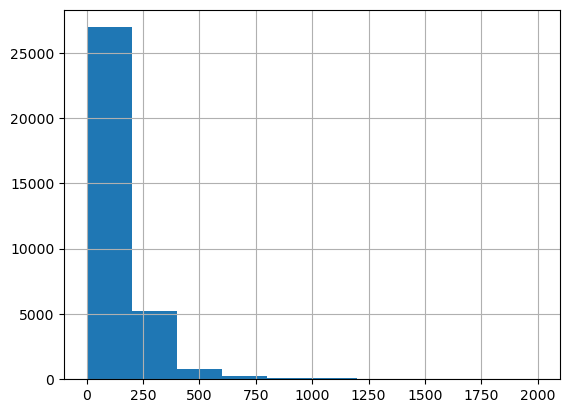

In [200]:
df['price'].hist()

In [214]:
too_expensive_idx = temp[temp['price'] > 900].index

In [215]:
temp = temp.drop(too_expensive_idx, axis=0)

In [220]:
xgb_t = XGBRegressor()

In [221]:
xgb_t.fit(temp.drop('price', axis=1), temp['price'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [222]:
# train accuracy - RMSE
np.sqrt(sum((xgb_t.predict(X2_train) - y2_train)**2) / len(y2_train))

98.98789376506603

In [223]:
# val accuracy
np.sqrt(sum((xgb_t.predict(X2_val) - y2_val)**2) / len(y2_val))

98.86973201712858

In [225]:
test_pred_t = xgb_t.predict(cleaned_test)
pd.DataFrame(index=test.index, data=test_pred_t, columns=['Predicted']).to_csv('preds6-4.csv')